In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trkiye-il-ile-listesi/il_ilce.csv
/kaggle/input/datathon-2024/sample_submission.csv
/kaggle/input/datathon-2024/test_x.csv
/kaggle/input/datathon-2024/train.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import re
from datetime import datetime
import optuna
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
pd.set_option('display.width', 500)

In [3]:
train_df = pd.read_csv("/kaggle/input/datathon-2024/train.csv",encoding='utf-8',low_memory=False)
test_df = pd.read_csv("/kaggle/input/datathon-2024/test_x.csv",encoding='utf-8',low_memory=False)
il_ilce = pd.read_csv("/kaggle/input/trkiye-il-ile-listesi/il_ilce.csv")
submission_df = pd.read_csv("/kaggle/input/datathon-2024/sample_submission.csv",encoding='utf-8',low_memory=False)

In [4]:
def check_df(dataframe):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.nunique())
    print("############################################")
    print(dataframe.isnull().sum())
    
check_df(train_df)

############################################
(65125, 44)
############################################
Basvuru Yili                                                   int64
Degerlendirme Puani                                          float64
Cinsiyet                                                      object
Dogum Tarihi                                                  object
Dogum Yeri                                                    object
Ikametgah Sehri                                               object
Universite Adi                                                object
Universite Turu                                               object
Burslu ise Burs Yuzdesi                                      float64
Burs Aliyor mu?                                               object
Bölüm                                                         object
Universite Kacinci Sinif                                      object
Universite Not Ortalamasi                                     object
D

In [5]:
def check_df(dataframe):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.nunique())
    print("############################################")
    print(dataframe.isnull().sum())
    
check_df(test_df)

############################################
(11049, 43)
############################################
Basvuru Yili                                                   int64
Cinsiyet                                                      object
Dogum Tarihi                                                  object
Dogum Yeri                                                    object
Ikametgah Sehri                                               object
Universite Adi                                                object
Universite Turu                                               object
Burslu ise Burs Yuzdesi                                      float64
Burs Aliyor mu?                                               object
Bölüm                                                         object
Universite Kacinci Sinif                                      object
Universite Not Ortalamasi                                     object
Daha Once Baska Bir Universiteden Mezun Olmus                float64
L

In [6]:
train_df.head()

,Basvuru Yili,Degerlendirme Puani,Cinsiyet,Dogum Tarihi,Dogum Yeri,Ikametgah Sehri,Universite Adi,Universite Turu,Burslu ise Burs Yuzdesi,Burs Aliyor mu?,Bölüm,Universite Kacinci Sinif,Universite Not Ortalamasi,Daha Once Baska Bir Universiteden Mezun Olmus,Lise Adi,Lise Adi Diger,Lise Sehir,Lise Turu,Lise Bolumu,Lise Bolum Diger,Lise Mezuniyet Notu,Baska Bir Kurumdan Burs Aliyor mu?,Burs Aldigi Baska Kurum,Baska Kurumdan Aldigi Burs Miktari,Anne Egitim Durumu,Anne Calisma Durumu,Anne Sektor,Baba Egitim Durumu,Baba Calisma Durumu,Baba Sektor,Kardes Sayisi,Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?,Uye Oldugunuz Kulubun Ismi,Profesyonel Bir Spor Daliyla Mesgul musunuz?,Spor Dalindaki Rolunuz Nedir?,Aktif olarak bir STK üyesi misiniz?,Hangi STK'nin Uyesisiniz?,Stk Projesine Katildiniz Mi?,Girisimcilikle Ilgili Deneyiminiz Var Mi?,Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?,Ingilizce Biliyor musunuz?,Ingilizce Seviyeniz?,"Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite",id
0,2014,52.000,Erkek,4/6/1994,"Altindag, Ankara",Ankara,İHSAN DOĞRAMACI BİLKENT,Özel,100.000,Evet,Bilgisayar Muhendisligi,3,3.50-3,Hayır,Ankara Ataturk Anadolu Lisesi,NaN,Ankara,Anadolu lisesi,MF,NaN,3.50-3,Hayır,NaN,NaN,Üniversite,Hayır,0,Üniversite,Emekli,0,1,Evet,Bilkent IEEE Bilgisayar Toplulugu 2013-2014 Ba...,Evet,Diğer,Hayır,NaN,Evet,Hayır,NaN,NaN,NaN,NaN,0
1,2014,30.000,Erkek,6/11/1993,Üsküdar,İstanbul,İHSAN DOĞRAMACI BİLKENT,Özel,100.000,Hayır,Elektrik Elektronik Mühendisliği,3,3.00-2.50,Hayır,Betül Can Anadolu Lisesi,NaN,Ankara,Anadolu lisesi,MF,NaN,3.00 - 4.00,Hayır,NaN,NaN,Üniversite,Evet,Kamu,Yüksek Lisans / Doktora,Emekli,0,1,Hayır,NaN,Hayır,0,Hayır,NaN,Evet,Evet,Bilkent Cyberparkta bir şirkette Türkiye nin i...,NaN,NaN,NaN,1
2,2014,18.000,Erkek,1/15/1986,Samsun,İstanbul,ULUSLARARASI KIBRIS ÜNİVERSİTESİ,Özel,100.000,Hayır,Finans Yönetimi ve Pazarlama,1,NaN,Hayır,Batem,NaN,Ankara,Meslek lisesi,Elektirk,NaN,3.50-3,Hayır,NaN,NaN,İlkokul Mezunu,Hayır,0,İlkokul Mezunu,Evet,Özel Sektör,6,Evet,Tema,Hayır,0,Hayır,NaN,Hayır,Hayır,NaN,NaN,NaN,NaN,2
3,2014,40.000,Erkek,6/4/1991,Diyarbakır,İstanbul,İSTANBUL ŞEHİR ÜNİVERSİTESİ,Özel,100.000,Evet,Bilgisayar Mühendisliği,3,3.00-2.50,Hayır,Cumhuriyet Fen Lisesi,NaN,Diyarbakır,Fen lisesi,Sayısal,NaN,3.50-3,Hayır,NaN,NaN,İlkokul Mezunu,Hayır,0,Üniversite,Emekli,0,10,Evet,Güzel Konuşma ve yazma kulübü,Hayır,0,Hayır,NaN,Evet,Hayır,NaN,NaN,NaN,NaN,3
4,2014,24.000,Erkek,2 Kasim 1992,Ankara/Altındağ,Ankara,TURGUT ÖZAL ÜNİVERSİTESİ,Özel,100.000,Evet,Siyaset Bilimi ve Uluslararası ilişkiler,NaN,3.00-2.50,Hayır,Samanyolu Lisesi,NaN,Ankara,Özel lisesi,TM,NaN,3.00 - 4.00,Hayır,NaN,NaN,İlkokul Mezunu,Hayır,0,Üniversite,Emekli,0,1,Hayır,NaN,Hayır,0,Hayır,NaN,Hayır,Hayır,NaN,NaN,NaN,NaN,4


In [7]:
drop_null_cols = [col for col in train_df.columns if train_df[col].isnull().sum() > 13000]
drop_null_cols = drop_null_cols + ["Burslu ise Burs Yuzdesi", "Daha Once Baska Bir Universiteden Mezun Olmus",
                                   "Lise Adi Diger", "Lise Bolum Diger", "Uye Oldugunuz Kulubun Ismi", "Stk Projesine Katildiniz Mi?",
                                   "Ingilizce Seviyeniz?", "Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite"]
drop_null_cols = [col for col in drop_null_cols if col not in ["Baska Kurumdan Aldigi Burs Miktari"]]
drop_null_cols
train_df.drop(columns = drop_null_cols, inplace=True)
test_df.drop(columns = drop_null_cols, inplace=True)

In [8]:
train_df[train_df.select_dtypes(include='object').columns] = train_df.select_dtypes(include='object').apply(lambda x: x.str.upper())
test_df[test_df.select_dtypes(include='object').columns] = test_df.select_dtypes(include='object').apply(lambda x: x.str.upper())
il_ilce[il_ilce.select_dtypes(include='object').columns] = il_ilce.select_dtypes(include='object').apply(lambda x: x.str.upper())

train_df[train_df.select_dtypes(include='object').columns] = train_df.select_dtypes(include='object').apply(lambda x: x.str.replace('İ', 'I').str.replace('Ü', 'U').str.replace('Ö', 'O').str.replace('Ğ', 'G').str.replace('Ç', 'C').str.replace('Ş', 'S'))
test_df[test_df.select_dtypes(include='object').columns] = test_df.select_dtypes(include='object').apply(lambda x: x.str.replace('İ', 'I').str.replace('Ü', 'U').str.replace('Ö', 'O').str.replace('Ğ', 'G').str.replace('Ç', 'C').str.replace('Ş', 'S'))
il_ilce[il_ilce.select_dtypes(include='object').columns] = il_ilce.select_dtypes(include='object').apply(lambda x: x.str.replace('İ', 'I').str.replace('Ü', 'U').str.replace('Ö', 'O').str.replace('Ğ', 'G').str.replace('Ç', 'C').str.replace('Ş', 'S'))


In [9]:
train_df.isnull().sum()

Basvuru Yili                                                0
Degerlendirme Puani                                         1
Cinsiyet                                                  169
Dogum Tarihi                                              177
Dogum Yeri                                                791
Ikametgah Sehri                                          2037
Universite Adi                                            132
Universite Turu                                           255
Burs Aliyor mu?                                             0
Bölüm                                                     231
Universite Kacinci Sinif                                  374
Universite Not Ortalamasi                                2753
Lise Adi                                                  384
Lise Sehir                                               1054
Lise Turu                                                 847
Lise Bolumu                                              1009
Lise Mez

Feature Engineering

*SPOR*

In [10]:
"""
train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"] = train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].fillna("BILINMIYOR")

train_df.loc[train_df["Spor Dalindaki Rolunuz Nedir?"].str.contains('KAPTAN', case=False, na=False), 'Spor_Rol'] = "KAPTAN"
train_df.loc[train_df["Spor Dalindaki Rolunuz Nedir?"].str.contains('BIREYSEL', case=False, na=False), 'Spor_Rol'] = "BIREYSEL"
train_df.loc[train_df["Spor Dalindaki Rolunuz Nedir?"].str.contains('TAKIM OYUNCUSU', case=False, na=False), 'Spor_Rol'] = "TAKIM OYUNCUSU"
train_df.loc[train_df["Spor Dalindaki Rolunuz Nedir?"].str.contains('DIGER|0|-', case=False, na=False), 'Spor_Rol'] = "BILINMIYOR"
train_df.loc[train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].str.contains('BILINMIYOR', case=False, na=False), 'Spor_Rol'] = "BILINMIYOR"
train_df.loc[train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].str.contains('HAYIR', case=False, na=False), 'Spor_Rol'] = "ILGILENMIYOR"


test_df.loc[test_df["Spor Dalindaki Rolunuz Nedir?"].str.contains('KAPTAN', case=False, na=False), 'Spor_Rol'] = "KAPTAN"
test_df.loc[test_df["Spor Dalindaki Rolunuz Nedir?"].str.contains('BIREYSEL SPOR', case=False, na=False), 'Spor_Rol'] = "BIREYSEL"
test_df.loc[test_df["Spor Dalindaki Rolunuz Nedir?"].str.contains('TAKIM OYUNCUSU', case=False, na=False), 'Spor_Rol'] = "TAKIM OYUNCUSU"
test_df.loc[test_df["Spor Dalindaki Rolunuz Nedir?"].str.contains('DIGER|-', case=False, na=False), 'Spor_Rol'] = "BILINMIYOR"
test_df.loc[test_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].str.contains('HAYIR', case=False, na=False), 'Spor_Rol'] = "ILGILENMIYOR"

                                                        
train_df["Spor_Rol"] = train_df["Spor_Rol"].fillna("BILINMIYOR")
test_df["Spor_Rol"] = train_df["Spor_Rol"].fillna("BILINMIYOR")

train_df.drop(columns = ["Spor Dalindaki Rolunuz Nedir?"], inplace=True)
test_df.drop(columns = ["Spor Dalindaki Rolunuz Nedir?"], inplace=True)
"""

'\ntrain_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"] = train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].fillna("BILINMIYOR")\n\ntrain_df.loc[train_df["Spor Dalindaki Rolunuz Nedir?"].str.contains(\'KAPTAN\', case=False, na=False), \'Spor_Rol\'] = "KAPTAN"\ntrain_df.loc[train_df["Spor Dalindaki Rolunuz Nedir?"].str.contains(\'BIREYSEL\', case=False, na=False), \'Spor_Rol\'] = "BIREYSEL"\ntrain_df.loc[train_df["Spor Dalindaki Rolunuz Nedir?"].str.contains(\'TAKIM OYUNCUSU\', case=False, na=False), \'Spor_Rol\'] = "TAKIM OYUNCUSU"\ntrain_df.loc[train_df["Spor Dalindaki Rolunuz Nedir?"].str.contains(\'DIGER|0|-\', case=False, na=False), \'Spor_Rol\'] = "BILINMIYOR"\ntrain_df.loc[train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].str.contains(\'BILINMIYOR\', case=False, na=False), \'Spor_Rol\'] = "BILINMIYOR"\ntrain_df.loc[train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].str.contains(\'HAYIR\', case=False, na=False), \'Spor_Rol\'] = "ILGILENMIYOR"\n\n\ntest_df.l

*GİRİŞİMCİ*

In [11]:
"""
train_df.loc[train_df["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].str.contains('GIRISIM|SIRKET', case=False, na=False), 'Girişimci'] = 1
test_df.loc[test_df["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].str.contains('GIRISIM|SIRKET', case=False, na=False), 'Girişimci'] = 1
                                                              
train_df["Girişimci"] = train_df["Girişimci"].fillna(0)
test_df["Girişimci"] = train_df["Girişimci"].fillna(0)

train_df.drop(columns = ["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"], inplace=True)
test_df.drop(columns = ["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"], inplace=True)
"""

'\ntrain_df.loc[train_df["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].str.contains(\'GIRISIM|SIRKET\', case=False, na=False), \'Girişimci\'] = 1\ntest_df.loc[test_df["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].str.contains(\'GIRISIM|SIRKET\', case=False, na=False), \'Girişimci\'] = 1\n                                                              \ntrain_df["Girişimci"] = train_df["Girişimci"].fillna(0)\ntest_df["Girişimci"] = train_df["Girişimci"].fillna(0)\n\ntrain_df.drop(columns = ["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"], inplace=True)\ntest_df.drop(columns = ["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"], inplace=True)\n'

*Hangi STK*

In [12]:
"""
train_df.loc[train_df["Hangi STK'nin Uyesisiniz?"].str.contains('AIESEC|TEMA|LOSEV|KIZILAY|YESILAY|TOG|TEGV|GREENPEACE|AKUT|YGA|TOPLUM|EGİTİM', 
                                                                case=False, na=False), 'STK'] = 1
test_df.loc[test_df["Hangi STK'nin Uyesisiniz?"].str.contains('AIESEC|TEMA|LOSEV|KIZILAY|YESILAY|TOG|TEGV|GREENPEACE|AKUT|YGA|TOPLUM|EGİTİM', 
                                                              case=False, na=False), 'STK'] = 1
                                                              
train_df["STK"] = train_df["STK"].fillna(0)
test_df["STK"] = train_df["STK"].fillna(0)

train_df.drop(columns = ["Hangi STK'nin Uyesisiniz?"], inplace=True)
test_df.drop(columns = ["Hangi STK'nin Uyesisiniz?"], inplace=True) 
"""

'\ntrain_df.loc[train_df["Hangi STK\'nin Uyesisiniz?"].str.contains(\'AIESEC|TEMA|LOSEV|KIZILAY|YESILAY|TOG|TEGV|GREENPEACE|AKUT|YGA|TOPLUM|EGİTİM\', \n                                                                case=False, na=False), \'STK\'] = 1\ntest_df.loc[test_df["Hangi STK\'nin Uyesisiniz?"].str.contains(\'AIESEC|TEMA|LOSEV|KIZILAY|YESILAY|TOG|TEGV|GREENPEACE|AKUT|YGA|TOPLUM|EGİTİM\', \n                                                              case=False, na=False), \'STK\'] = 1\n                                                              \ntrain_df["STK"] = train_df["STK"].fillna(0)\ntest_df["STK"] = train_df["STK"].fillna(0)\n\ntrain_df.drop(columns = ["Hangi STK\'nin Uyesisiniz?"], inplace=True)\ntest_df.drop(columns = ["Hangi STK\'nin Uyesisiniz?"], inplace=True) \n'

*Burs Miktarı*

In [13]:
def clean_burs(burs_value):
    # TL, ₺, LIRA gibi ifadeleri kaldır
    
    if not isinstance(burs_value, str):
        return None
    
    burs_value = re.sub(r'TL|₺|LIRA|YTL', '', burs_value)
    
    # "AYLIK", "TOPLAM", "YILLIK" gibi metinleri kaldır
    burs_value = re.sub(r'AYLIK|TOPLAM|YILLIK', '', burs_value, flags=re.IGNORECASE)
    
    # Metin içeren satırları (burs miktarını belirtmeyen) boş bırak
    if not re.search(r'\d+', burs_value):
        return None
    
    # Sadece sayıları ve virgülleri tut
    burs_value = re.findall(r'\d+', burs_value)
    
    # Birden fazla sayı varsa, ortalamasını veya toplamını alabilirsin. Burada ortalama alınmıştır.
    if len(burs_value) > 1:
        return sum(map(int, burs_value)) // len(burs_value)
    return int(burs_value[0])

# Temizleme işlemi
train_df['Parasal_Burs'] = train_df['Baska Kurumdan Aldigi Burs Miktari'].apply(clean_burs)
test_df['Parasal_Burs'] = test_df['Baska Kurumdan Aldigi Burs Miktari'].apply(clean_burs)

train_df.loc[train_df["Baska Kurumdan Aldigi Burs Miktari"] == "BIN TURK LIRASI", "Parasal_Burs"] = 1000
train_df.loc[train_df["Baska Kurumdan Aldigi Burs Miktari"] == "UCYUZ LIRA", "Parasal_Burs"] = 300
train_df.loc[train_df["Baska Kurumdan Aldigi Burs Miktari"] == "KYK", "Parasal_Burs"] = 425
train_df.loc[train_df["Baska Kurumdan Aldigi Burs Miktari"] == "SPOR GENCLIK BAKANLIGI", "Parasal_Burs"] = 425
train_df.loc[train_df["Baska Kurumdan Aldigi Burs Miktari"] == "GERI ODEMELI KYK BURSU", "Parasal_Burs"] = 425
train_df.loc[train_df["Baska Kurumdan Aldigi Burs Miktari"] == "KYK BURSU KADAR", "Parasal_Burs"] = 425

train_df["Parasal_Burs"] = train_df["Parasal_Burs"].fillna(0)
test_df["Parasal_Burs"] = test_df["Parasal_Burs"].fillna(0)

*İL İLÇE*

In [14]:
# İlçeleri il ile değiştirme işlemi
il_ilce_mapping = dict(zip(il_ilce['ilce'], il_ilce['il']))
train_df['Dogum_Yeri'] = train_df['Dogum Yeri'].replace(il_ilce_mapping, regex=True)

def clean_location(loc):
    if pd.isna(loc):
        return loc
    loc = str(loc)
    parts = re.split('[,/ -]', loc)
    for part in parts:
        part = part.strip().upper()
        if part in il_ilce_mapping:
            return il_ilce_mapping[part]
    return loc

train_df['Dogum_Yeri'] = train_df['Dogum Yeri'].apply(clean_location)


*DOĞUM YERİ*

In [15]:
train_df.loc[train_df["Dogum_Yeri"] == "CANAKKALE-MERKEZ", "Dogum_Yeri"] = "HATAY"
train_df.loc[train_df["Dogum_Yeri"] == "YUSUFELIARTVIN", "Dogum_Yeri"] = "ARTVIN"
train_df.loc[train_df["Dogum_Yeri"] == "BORCKAARTVIN", "Dogum_Yeri"] = "ARTVIN"
train_df.loc[train_df["Dogum_Yeri"] == "AMASYA MERKEZ", "Dogum_Yeri"] = "AMASYA"
train_df.loc[train_df["Dogum_Yeri"] == "KASTAMONUCIDE", "Dogum_Yeri"] = "KASTAMONU"
train_df.loc[train_df["Dogum_Yeri"] == "SULTANBELI-ISTANBUL", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "MALATYAMERKEZ", "Dogum_Yeri"] = "MALATYA"
train_df.loc[train_df["Dogum_Yeri"] == "MUGLA MERKEZ", "Dogum_Yeri"] = "MUGLA"
train_df.loc[train_df["Dogum_Yeri"] == "VAN MERKEZ", "Dogum_Yeri"] = "VAN"
train_df.loc[train_df["Dogum_Yeri"] == "KDZ.EREGLI", "Dogum_Yeri"] = "ZONGULDAK"
train_df.loc[train_df["Dogum_Yeri"] == "EMINONU", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "KAGITHANE/IST", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBUL-EMINONU", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "EYUP", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "ANKARA/K.OREN", "Dogum_Yeri"] = "ANKARA"
train_df.loc[train_df["Dogum_Yeri"] == "MERKEZ/TOKAT", "Dogum_Yeri"] = "TOKAT"
train_df.loc[train_df["Dogum_Yeri"] == "LEFKOSE", "Dogum_Yeri"] = "KKTC"
train_df.loc[train_df["Dogum_Yeri"] == "K.MARAS", "Dogum_Yeri"] = "KAHRAMANMARAS"
train_df.loc[train_df["Dogum_Yeri"] == "NIGDE - MERKEZ", "Dogum_Yeri"] = "NIGDE"
train_df.loc[train_df["Dogum_Yeri"] == "ESKISEHIR/MERKEZ", "Dogum_Yeri"] = "ESKISEHIR"
train_df.loc[train_df["Dogum_Yeri"] == "ZONGULDAK/ MERKEZ", "Dogum_Yeri"] = "ZONGULDAK"
train_df.loc[train_df["Dogum_Yeri"] == "BOLU MERKEZ", "Dogum_Yeri"] = "BOLU"
train_df.loc[train_df["Dogum_Yeri"] == "NAZIILI / AYDIN", "Dogum_Yeri"] = "AYDIN"
train_df.loc[train_df["Dogum_Yeri"] == "KKTC/MAGOSA", "Dogum_Yeri"] = "KKTC"
train_df.loc[train_df["Dogum_Yeri"] == "AFYON", "Dogum_Yeri"] = "AFYONKARAHISAR"
train_df.loc[train_df["Dogum_Yeri"] == "?IRIKKALE", "Dogum_Yeri"] = "KIRIKKALE"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBUL/TURKIYE", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBUL EMINONU", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "LEVENT/IST", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "KAGITHANE", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "USKIDAR", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "GOSTEPE/ISTANBUL", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "BAKIRKOYISTANBUL", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "K.CEKMECE", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "SELCUKULU/KONYA", "Dogum_Yeri"] = "KONYA"
train_df.loc[train_df["Dogum_Yeri"] == "KOSKLUCIFTLIK- LEFKOSA", "Dogum_Yeri"] = "KKTC"
train_df.loc[train_df["Dogum_Yeri"] == "SIVAS/MERKEZ", "Dogum_Yeri"] = "SIVAS"
train_df.loc[train_df["Dogum_Yeri"] == "KONYASELCUKLU", "Dogum_Yeri"] = "KONYA"
train_df.loc[train_df["Dogum_Yeri"] == "KAHRAMANMARAS/MERKEZ", "Dogum_Yeri"] = "KAHRAMANMARAS"
train_df.loc[train_df["Dogum_Yeri"] == "MUGLA/MERKEZ", "Dogum_Yeri"] = "MUGLA"
train_df.loc[train_df["Dogum_Yeri"] == "ERURUM", "Dogum_Yeri"] = "ERZURUM"
train_df.loc[train_df["Dogum_Yeri"] == "LEFKOSA", "Dogum_Yeri"] = "KKTC"
train_df.loc[train_df["Dogum_Yeri"] == "D.BAYAZIT/ AGRI", "Dogum_Yeri"] = "AGRI"
train_df.loc[train_df["Dogum_Yeri"] == "MALATYA/MERKEZ", "Dogum_Yeri"] = "MALATYA"
train_df.loc[train_df["Dogum_Yeri"] == "CORUM MERKEZ", "Dogum_Yeri"] = "CORUM"
train_df.loc[train_df["Dogum_Yeri"] == "ADIYAMAN / MERKEZ", "Dogum_Yeri"] = "ADIYAMAN"
train_df.loc[train_df["Dogum_Yeri"] == "KDZ.EREGLI/ZONGULDAK", "Dogum_Yeri"] = "ZONGULDAK"
train_df.loc[train_df["Dogum_Yeri"] == "YENIMAHALLEANKARA", "Dogum_Yeri"] = "ANKARA"
train_df.loc[train_df["Dogum_Yeri"] == "ELAZIG/MERKEZ", "Dogum_Yeri"] = "ANKARA"
train_df.loc[train_df["Dogum_Yeri"] == "BOLU-MERKEZ", "Dogum_Yeri"] = "ANKARA"
train_df.loc[train_df["Dogum_Yeri"] == "GLRESUN", "Dogum_Yeri"] = "GIRESUN"
train_df.loc[train_df["Dogum_Yeri"] == "KILIS/MERKEZ", "Dogum_Yeri"] = "KILIS"
train_df.loc[train_df["Dogum_Yeri"] == "SIVAS MERKEZ", "Dogum_Yeri"] = "SIVAS"
train_df.loc[train_df["Dogum_Yeri"] == "ERKEZ/AKSARAY", "Dogum_Yeri"] = "AKSARAY"
train_df.loc[train_df["Dogum_Yeri"] == "GAZIANTEPNIZIP", "Dogum_Yeri"] = "GAZIANTEP"
train_df.loc[train_df["Dogum_Yeri"] == "TOKAT/ MERKEZ", "Dogum_Yeri"] = "TOKAT"
train_df.loc[train_df["Dogum_Yeri"] == "CEKIRGE", "Dogum_Yeri"] = "BURSA"
train_df.loc[train_df["Dogum_Yeri"] == "MERKEZ/AKSARAY", "Dogum_Yeri"] = "AKSARAY"
train_df.loc[train_df["Dogum_Yeri"] == "BALIKESIR / BURHANSYE", "Dogum_Yeri"] = "BALIKESIR"
train_df.loc[train_df["Dogum_Yeri"] == "DENIZLI MERKEZ", "Dogum_Yeri"] = "DENIZLI"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBUL/EYUP", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "MERKEZ/ELAZIG", "Dogum_Yeri"] = "ELAZIG"
train_df.loc[train_df["Dogum_Yeri"] == "SANSUN", "Dogum_Yeri"] = "SAMSUN"
train_df.loc[train_df["Dogum_Yeri"] == "DIYARBAKIR/ MERKEZ", "Dogum_Yeri"] = "DIYARBAKIR"
train_df.loc[train_df["Dogum_Yeri"] == "TAKSIM/ISTANBUL", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "CORUM/TURKIYE", "Dogum_Yeri"] = "CORUM"
train_df.loc[train_df["Dogum_Yeri"] == "MUS MERKEZ", "Dogum_Yeri"] = "MUS"
train_df.loc[train_df["Dogum_Yeri"] == "DUZCE/MERKEZ", "Dogum_Yeri"] = "DUZCE"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBUL-GOZTEPE", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "TRABZON MERKEZ", "Dogum_Yeri"] = "TRABZON"
train_df.loc[train_df["Dogum_Yeri"] == "YUMURTALIKADANA", "Dogum_Yeri"] = "ADANA"
train_df.loc[train_df["Dogum_Yeri"] == "BURSAYILDIRIM", "Dogum_Yeri"] = "BURSA"
train_df.loc[train_df["Dogum_Yeri"] == "YENI MAHALLE /ANKARA", "Dogum_Yeri"] = "ANKARA"
train_df.loc[train_df["Dogum_Yeri"] == "EMNONU", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "ANKARA/YENIMAHHALE", "Dogum_Yeri"] = "ANKARA"
train_df.loc[train_df["Dogum_Yeri"] == "KUTAHYATAVSANLI", "Dogum_Yeri"] = "KUTAHYA"
train_df.loc[train_df["Dogum_Yeri"] == "OSMAN GAZI / BURSA", "Dogum_Yeri"] = "BURSA"
train_df.loc[train_df["Dogum_Yeri"] == "GEDIZKUTAHYA", "Dogum_Yeri"] = "KUTAHYA"
train_df.loc[train_df["Dogum_Yeri"] == "TEKIRDAGCORLU", "Dogum_Yeri"] = "TEKIRDAG"
train_df.loc[train_df["Dogum_Yeri"] == "ORDUUNYE", "Dogum_Yeri"] = "ORDU"
train_df.loc[train_df["Dogum_Yeri"] == "KAMANKIRSHIR", "Dogum_Yeri"] = "KIRSEHIR"
train_df.loc[train_df["Dogum_Yeri"] == "KESAN", "Dogum_Yeri"] = "EDIRNE"
train_df.loc[train_df["Dogum_Yeri"] == "AYDIN / MERKEZ", "Dogum_Yeri"] = "AYDIN"
train_df.loc[train_df["Dogum_Yeri"] == "HATAY ISKEBDERUN", "Dogum_Yeri"] = "HATAY"
train_df.loc[train_df["Dogum_Yeri"] == "CUMHURIYET MAHALLESI.LALE SOKAK.ERDIL APARTMANI.NO:16 DAIRE:2", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "ERZINCA", "Dogum_Yeri"] = "ERZINCAN"
train_df.loc[train_df["Dogum_Yeri"] == "M.K.PASA/BURSA", "Dogum_Yeri"] = "BURSA"
train_df.loc[train_df["Dogum_Yeri"] == "S.URFA", "Dogum_Yeri"] = "SANLIURFA"
train_df.loc[train_df["Dogum_Yeri"] == "TOKAT-MERKEZ", "Dogum_Yeri"] = "TOKAT"
train_df.loc[train_df["Dogum_Yeri"] == "AGRI/DOGUBEYAZIT", "Dogum_Yeri"] = "AGRI"
train_df.loc[train_df["Dogum_Yeri"] == "IZMIRKONAK", "Dogum_Yeri"] = "IZMIR"
train_df.loc[train_df["Dogum_Yeri"] == "TURKOGU/KAHRAMANMARAS", "Dogum_Yeri"] = "KAHRAMANMARAS"
train_df.loc[train_df["Dogum_Yeri"] == "KARAMAN/MERKEZ", "Dogum_Yeri"] = "KARAMAN"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBUL EYUP", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "DIYARBAKIRDICLE", "Dogum_Yeri"] = "DIYARBAKIR"
train_df.loc[train_df["Dogum_Yeri"] == "G.ANTEP", "Dogum_Yeri"] = "GAZIANTEP"
train_df.loc[train_df["Dogum_Yeri"] == "MERKEZ/AYDIN", "Dogum_Yeri"] = "AYDIN"
train_df.loc[train_df["Dogum_Yeri"] == "ESKISEIR", "Dogum_Yeri"] = "ESKISEHIR"
train_df.loc[train_df["Dogum_Yeri"] == "KESAN.", "Dogum_Yeri"] = "EDIRNE"
train_df.loc[train_df["Dogum_Yeri"] == "ZONGULDAK / MERKEZ", "Dogum_Yeri"] = "ZONGULDAK"
train_df.loc[train_df["Dogum_Yeri"] == "SAMSUN-MERKEZ", "Dogum_Yeri"] = "SAMSUN"
train_df.loc[train_df["Dogum_Yeri"] == "EYUP/ISTANBUL", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "AMASYA / MERKEZ", "Dogum_Yeri"] = "AMASYA"
train_df.loc[train_df["Dogum_Yeri"] == "EMINONU ISTANBUL", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "KADIOY/ISTANBUL", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "SULTANAHMET K.AYASOFYA/KAYITTA EMINONU", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "KARAISALIADANA", "Dogum_Yeri"] = "ADANA"
train_df.loc[train_df["Dogum_Yeri"] == "KIRIKKALE/MERKEZ", "Dogum_Yeri"] = "KIRIKKALE"
train_df.loc[train_df["Dogum_Yeri"] == "SULTANBELI/IST.", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "AGRI DOGUBEYAZIT", "Dogum_Yeri"] = "AGRI"
train_df.loc[train_df["Dogum_Yeri"] == "TAKSIM", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "ADIYAMAN/MERKEZ", "Dogum_Yeri"] = "ADIYAMAN"
train_df.loc[train_df["Dogum_Yeri"] == "AGRI MERKEZ", "Dogum_Yeri"] = "AGRI"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBUL_USKUDAR", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "MERKEZ-BARTIN", "Dogum_Yeri"] = "BARTIN"
train_df.loc[train_df["Dogum_Yeri"] == "RIZE/MERKEZ", "Dogum_Yeri"] = "RIZE"
train_df.loc[train_df["Dogum_Yeri"] == "DUZCE / MERKEZ", "Dogum_Yeri"] = "DUZCE"
train_df.loc[train_df["Dogum_Yeri"] == "POLATLI_ANKARA", "Dogum_Yeri"] = "ANKARA"
train_df.loc[train_df["Dogum_Yeri"] == "MRSIN", "Dogum_Yeri"] = "MERSIN"
train_df.loc[train_df["Dogum_Yeri"] == "SALIHLIMANISA", "Dogum_Yeri"] = "MANISA"
train_df.loc[train_df["Dogum_Yeri"] == "SINCANLI - AFYON", "Dogum_Yeri"] = "AFYONKARAHISAR"
train_df.loc[train_df["Dogum_Yeri"] == "MERKEZ/SANLIURFA", "Dogum_Yeri"] = "SANLIURFA"
train_df.loc[train_df["Dogum_Yeri"] == "G.O.PASA", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBUL/AKSARAY", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "MERKEZ/MANISA", "Dogum_Yeri"] = "MANISA"
train_df.loc[train_df["Dogum_Yeri"] == "ISPARTA/MERKEZ", "Dogum_Yeri"] = "ISPARTA"
train_df.loc[train_df["Dogum_Yeri"] == "MANISA- MERKEZ", "Dogum_Yeri"] = "MANISA"
train_df.loc[train_df["Dogum_Yeri"] == "ISTANBULBAKIRKOY", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "KARABUK / MERKEZ", "Dogum_Yeri"] = "KARABUK"
train_df.loc[train_df["Dogum_Yeri"] == "MERKEZ / TOKAT", "Dogum_Yeri"] = "TOKAT"
train_df.loc[train_df["Dogum_Yeri"] == "SIIVAS", "Dogum_Yeri"] = "SIVAS"
train_df.loc[train_df["Dogum_Yeri"] == "SIVAS -MERKEZ", "Dogum_Yeri"] = "SIVAS"
train_df.loc[train_df["Dogum_Yeri"] == "KASTAMONU/MERKEZ", "Dogum_Yeri"] = "KASTAMONU"
train_df.loc[train_df["Dogum_Yeri"] == "DOGUBEYAZIT", "Dogum_Yeri"] = "AGRI"
train_df.loc[train_df["Dogum_Yeri"] == "AKSARAY/ MERKEZ", "Dogum_Yeri"] = "AKSARAY"
train_df.loc[train_df["Dogum_Yeri"] == "ANKAR7", "Dogum_Yeri"] = "ANKARA"
train_df.loc[train_df["Dogum_Yeri"] == "SANLUIRFA", "Dogum_Yeri"] = "SANLIURFA"
train_df.loc[train_df["Dogum_Yeri"] == "ADANASEYHAN", "Dogum_Yeri"] = "ADANA"
train_df.loc[train_df["Dogum_Yeri"] == "BITLIS/MERKEZ", "Dogum_Yeri"] = "BITLIS"
train_df.loc[train_df["Dogum_Yeri"] == "EMINONU-ISTANBUL", "Dogum_Yeri"] = "ISTANBUL"
train_df.loc[train_df["Dogum_Yeri"] == "VEZIRKORU", "Dogum_Yeri"] = "SAMSUN"
train_df.loc[train_df["Dogum_Yeri"] == "HAKKÂRI", "Dogum_Yeri"] = "HAKKARI"



train_df.loc[train_df["Dogum_Yeri"] == "GROSS-UMSTADTALMANYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "ABINGTON / USA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "STATE COLLEGE ABD", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "MELBOURNE/AVUSTRALIA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KAZAKISTAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "RUSYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "MEKKE/S.ARABISTAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "MEKKE", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "BRISTOL", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "TRABLUS / LIBYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "SUUDI ARABISTAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "VIYANA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KAHIRE", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "BAKU", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "EDE/HOLLANDA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KÂHTA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "GURCISTAN / BOLNISI", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "BORCKAARTVIN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "TEHRAN / IRAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KACANIK, KOSOVA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "AZERBEYCAN AHISKA TURKU", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KOPNYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "BAKU, AZERBAYCAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "ISVICRE/RHEINFELDEN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "ALMANYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "NOTTINGHAM/ INGILTERE", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "NOTTINGHAM/ INGILTERE", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "ALABAMA/ABD", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "DUISBURG", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "WUPPERTAL ALMANYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "STUTTGART / ALMANYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "BRATOSH, SHKODER, ARNAVUTLUK", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "AZERBAYCAN / BAKU", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "ALIAGAIZMIR", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KIRGIZISTAN/OS", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "CIDDE/SJ", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KOLN / ALMANYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "BOLTON - INGILTERE", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "TACIKISTAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "HOF/ALMANYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KÂHTA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "CHARSADDA-PAKISTAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "AZERBAYCAN,BAKU", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "BULGARISTAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KAZAKISTAN TURK VATANDASIYIM", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "UKRAYNA/SEVASTOPOL", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KAZAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "BERLIN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "DEMOKRATIK KONGO CUMHURIYETI KINSHASA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KIRCALI - BULGARISTAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "TERVEL/BULGARISTAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "GLEIZE / FRANSA 69400", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "ALMANYA/KEMPTEN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "MACOO", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "GERCUS.", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "SCHORNDORF/ALMANYA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "STOCKHOLM / ISVEC", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "SEKI,AZERBAYCAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "HOLLANDA", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "LAZKIYE, SURIYE", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "AZERBAYCAN", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "ALTINTS", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "KAHIRE/MISIR", "Dogum_Yeri"] = "YURT DISI"
train_df.loc[train_df["Dogum_Yeri"] == "34239", "Dogum_Yeri"] = "YURT DISI"

train_df = train_df[~train_df['Dogum_Yeri'].str.upper().isin(['TURKIYE', 'DIGER', '2/21/1991', "------"])]

train_df["Dogum_Yeri"] = train_df["Dogum_Yeri"].fillna("BILINMIYOR")

test_df["Dogum_Yeri"] = test_df["Dogum Yeri"]

train_df.drop(columns = ["Dogum Yeri"], inplace=True)
test_df.drop(columns = ["Dogum Yeri"], inplace=True)


*IKAMETGAH SEHRİ*

In [16]:
# İlçeleri il ile değiştirme işlemi
il_ilce_mapping = dict(zip(il_ilce['ilce'], il_ilce['il']))
train_df['Ikametgah_Sehri'] = train_df['Ikametgah Sehri'].replace(il_ilce_mapping, regex=True)

def clean_location(loc):
    if pd.isna(loc):
        return loc
    loc = str(loc)
    parts = re.split('[,/ -]', loc)
    for part in parts:
        part = part.strip().upper()
        if part in il_ilce_mapping:
            return il_ilce_mapping[part]
    return loc

train_df['Ikametgah_Sehri'] = train_df['Ikametgah Sehri'].apply(clean_location)

In [17]:
train_df.loc[train_df["Ikametgah_Sehri"] == "FLORYA/ISTANBUL", "Ikametgah_Sehri"] = "ISTANBUL"
train_df.loc[train_df["Ikametgah_Sehri"] == "GIRNE", "Ikametgah_Sehri"] = "KKTC"
train_df.loc[train_df["Ikametgah_Sehri"] == "GAZIMAGUSA", "Ikametgah_Sehri"] = "KKTC"
train_df.loc[train_df["Ikametgah_Sehri"] == "LEFKOSA", "Ikametgah_Sehri"] = "KKTC"
train_df.loc[train_df["Ikametgah_Sehri"] == "LEFKE", "Ikametgah_Sehri"] = "KKTC"
train_df.loc[train_df["Ikametgah_Sehri"] == "GAZIMAGUSA", "Ikametgah_Sehri"] = "KKTC"

train_df.loc[train_df["Ikametgah_Sehri"] == "K.MARAS", "Ikametgah_Sehri"] = "KAHRAMANMARAS"
train_df.loc[train_df["Ikametgah_Sehri"] == "STANBUL", "Ikametgah_Sehri"] = "ISTANBUL"
train_df.loc[train_df["Ikametgah_Sehri"] == "AFYON", "Ikametgah_Sehri"] = "AFYONKARAHISAR"
train_df.loc[train_df["Ikametgah_Sehri"] == "KAGITHANE/ISTANBUL", "Ikametgah_Sehri"] = "ISTANBUL"
train_df.loc[train_df["Ikametgah_Sehri"] == "BAHCESEHIR/ISTANBUL", "Ikametgah_Sehri"] = "ISTANBUL"
train_df.loc[train_df["Ikametgah_Sehri"] == "FERIKOY/ISTANBUL", "Ikametgah_Sehri"] = "ISTANBUL"
train_df.loc[train_df["Ikametgah_Sehri"] == "ISTANBUL\nNIGDE", "Ikametgah_Sehri"] = "ISTANBUL"
train_df.loc[train_df["Ikametgah_Sehri"] == "YENIBOSNA/ISTANBUL", "Ikametgah_Sehri"] = "ISTANBUL"
train_df.loc[train_df["Ikametgah_Sehri"] == "ISTANBUL,KOCAELI", "Ikametgah_Sehri"] = "ISTANBUL"
train_df.loc[train_df["Ikametgah_Sehri"] == "BATMAN/MERKEZ", "Ikametgah_Sehri"] = "BATMAN"
train_df.loc[train_df["Ikametgah_Sehri"] == "ERYAMAN/ANKARA", "Ikametgah_Sehri"] = "ANKARA"
train_df.loc[train_df["Ikametgah_Sehri"] == "HACETTEPE/ANKARA", "Ikametgah_Sehri"] = "ANKARA"
train_df.loc[train_df["Ikametgah_Sehri"] == "ODTU/ANKARA", "Ikametgah_Sehri"] = "ANKARA"
train_df.loc[train_df["Ikametgah_Sehri"] == "BILKENT/ANKARA", "Ikametgah_Sehri"] = "ANKARA"
train_df.loc[train_df["Ikametgah_Sehri"] == "MERKEZ/KASTAMONU", "Ikametgah_Sehri"] = "KASTAMONU"
train_df.loc[train_df["Ikametgah_Sehri"] == "MERSIN-ADANA", "Ikametgah_Sehri"] = "MERSIN"
train_df.loc[train_df["Ikametgah_Sehri"] == "İZMIR", "Ikametgah_Sehri"] = "IZMIR"
train_df.loc[train_df["Ikametgah_Sehri"] == "HAKKÂRI", "Ikametgah_Sehri"] = "HAKKARI"



train_df.loc[train_df["Ikametgah_Sehri"] == "HAMBURG", "Ikametgah_Sehri"] = "YURT DISI"
train_df.loc[train_df["Ikametgah_Sehri"] == "KIRGIZISTAN-BISKEK", "Ikametgah_Sehri"] = "YURT DISI"
train_df.loc[train_df["Ikametgah_Sehri"] == "NURNBERG", "Ikametgah_Sehri"] = "YURT DISI"
train_df.loc[train_df["Ikametgah_Sehri"] == "CIRISHANEE", "Ikametgah_Sehri"] = "YURT DISI"
train_df.loc[train_df["Ikametgah_Sehri"] == "GOTHAM", "Ikametgah_Sehri"] = "YURT DISI"
train_df.loc[train_df["Ikametgah_Sehri"] == "GOTHAMCITY", "Ikametgah_Sehri"] = "YURT DISI"
train_df.loc[train_df["Ikametgah_Sehri"] == "OSLO", "Ikametgah_Sehri"] = "YURT DISI"
train_df.loc[train_df["Ikametgah_Sehri"] == "OPENAIREQUESTFAILEDTIMEOUT", "Ikametgah_Sehri"] = "YURT DISI"
train_df.loc[train_df["Ikametgah_Sehri"] == "BAKU", "Ikametgah_Sehri"] = "YURT DISI"

train_df = train_df[~train_df['Ikametgah_Sehri'].str.upper().isin(['DIGER', "------"])]

train_df["Ikametgah_Sehri"] = train_df["Ikametgah_Sehri"].fillna("BILINMIYOR")

test_df["Ikametgah_Sehri"] = test_df["Ikametgah Sehri"]

train_df.drop(columns = ["Ikametgah Sehri"], inplace=True)
test_df.drop(columns = ["Ikametgah Sehri"], inplace=True)


*Lise Şehri*

In [18]:
import pandas as pd
import re



# İlçeleri il ile değiştirme işlemi
il_ilce_mapping = dict(zip(il_ilce['ilce'], il_ilce['il']))
train_df['Lise_Sehir'] = train_df['Lise Sehir'].replace(il_ilce_mapping, regex=True)

def clean_location(loc):
    if pd.isna(loc):
        return loc
    loc = str(loc)
    parts = re.split('[,/ -]', loc)
    for part in parts:
        part = part.strip().upper()
        if part in il_ilce_mapping:
            return il_ilce_mapping[part]
    return loc

train_df['Lise_Sehir'] = train_df['Lise Sehir'].apply(clean_location)

In [19]:
train_df.loc[train_df["Lise_Sehir"] == "KAHRAMANMAAS", "Lise_Sehir"] = "KAHRAMANMARAS"
train_df.loc[train_df["Lise_Sehir"] == "ISTANBUL ANADOLU", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "ANTAYA", "Lise_Sehir"] = "ANTALYA"
train_df.loc[train_df["Lise_Sehir"] == "TOKAT MERKEZ", "Lise_Sehir"] = "TOKAT"
train_df.loc[train_df["Lise_Sehir"] == "ERZURUN", "Lise_Sehir"] = "ERZURUM"
train_df.loc[train_df["Lise_Sehir"] == "ISTABUL", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "DENIZL", "Lise_Sehir"] = "DENIZLI"
train_df.loc[train_df["Lise_Sehir"] == "CANAKKLALE", "Lise_Sehir"] = "CANAKKALE"
train_df.loc[train_df["Lise_Sehir"] == "K.MARAS", "Lise_Sehir"] = "KAHRAMANMARAS"
train_df.loc[train_df["Lise_Sehir"] == "AFYON", "Lise_Sehir"] = "AFYONKARAHISAR"
train_df.loc[train_df["Lise_Sehir"] == ":ANKARA", "Lise_Sehir"] = "ANKARA"
train_df.loc[train_df["Lise_Sehir"] == "TEKIRDAG,ISTANBUL", "Lise_Sehir"] = "TEKIRDAG"
train_df.loc[train_df["Lise_Sehir"] == "KAHRAMANMRAS", "Lise_Sehir"] = "KAHRAMANMARAS"
train_df.loc[train_df["Lise_Sehir"] == "MUGLA/MERKEZ", "Lise_Sehir"] = "MUGLA"
train_df.loc[train_df["Lise_Sehir"] == "KURKCU", "Lise_Sehir"] = "SIVAS"
train_df.loc[train_df["Lise_Sehir"] == "KDZ.EREGLI", "Lise_Sehir"] = "ZONGULDAK"
train_df.loc[train_df["Lise_Sehir"] == "ISTANBUK", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "KASYERI", "Lise_Sehir"] = "KAYSERI"
train_df.loc[train_df["Lise_Sehir"] == "ANTALYA/VAN", "Lise_Sehir"] = "ANTALYA"
train_df.loc[train_df["Lise_Sehir"] == "KASYERI", "Lise_Sehir"] = "KAYSERI"
train_df.loc[train_df["Lise_Sehir"] == "ISYANBUL", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "MERKEZ /ELAZIG", "Lise_Sehir"] = "ELAZIG"
train_df.loc[train_df["Lise_Sehir"] == "DIYARAKIR", "Lise_Sehir"] = "DIYARBAKIR"
train_df.loc[train_df["Lise_Sehir"] == "ESKISEIR", "Lise_Sehir"] = "ESKISEHIR"
train_df.loc[train_df["Lise_Sehir"] == "GUMUSYAKA", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "SINOPBOYABAT", "Lise_Sehir"] = "SINOP"
train_df.loc[train_df["Lise_Sehir"] == "AANTALYA", "Lise_Sehir"] = "ANTALYA"
train_df.loc[train_df["Lise_Sehir"] == "GERMNCIK/AYDIN", "Lise_Sehir"] = "AYDIN"
train_df.loc[train_df["Lise_Sehir"] == "VAN - ELAZIG", "Lise_Sehir"] = "VAN"
train_df.loc[train_df["Lise_Sehir"] == "IGDIR / ISTANBUL / ISTANBUL", "Lise_Sehir"] = "IGDIR"
train_df.loc[train_df["Lise_Sehir"] == "MERKEZ/KASTAMONU", "Lise_Sehir"] = "KASTAMONU"
train_df.loc[train_df["Lise_Sehir"] == "MRSIN", "Lise_Sehir"] = "MERSIN"
train_df.loc[train_df["Lise_Sehir"] == "ZONGULDAK MERKEZ", "Lise_Sehir"] = "ZONGULDAK"
train_df.loc[train_df["Lise_Sehir"] == "ISTANBU", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "SANLIURFA/ MERKEZ", "Lise_Sehir"] = "SANLIURFA"
train_df.loc[train_df["Lise_Sehir"] == "BILECIK-MERKEZ", "Lise_Sehir"] = "BILECIK"
train_df.loc[train_df["Lise_Sehir"] == "NIZIPGAZIANTEP", "Lise_Sehir"] = "GAZIANTEP"
train_df.loc[train_df["Lise_Sehir"] == "ANKARA, BALIKESIR", "Lise_Sehir"] = "ANKARA"
train_df.loc[train_df["Lise_Sehir"] == "KARABBUK", "Lise_Sehir"] = "KARABUK"
train_df.loc[train_df["Lise_Sehir"] == "IST", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "AGRI/DOGUBEYAZIT", "Lise_Sehir"] = "AGRI"
train_df.loc[train_df["Lise_Sehir"] == "ISTANBUL HEYBELIADA", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "ANKAR", "Lise_Sehir"] = "ANKARA"
train_df.loc[train_df["Lise_Sehir"] == "HATAY3 YIL-OSMANIYE1", "Lise_Sehir"] = "HATAY"
train_df.loc[train_df["Lise_Sehir"] == "AFYON, IZMIR", "Lise_Sehir"] = "AFYONKARAHISAR"
train_df.loc[train_df["Lise_Sehir"] == "ERENKOY-ISTANBUL", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "BULUT", "Lise_Sehir"] = "RIZE"
train_df.loc[train_df["Lise_Sehir"] == "BAFRASAMSUN", "Lise_Sehir"] = "SAMSUN"
train_df.loc[train_df["Lise_Sehir"] == "ISRANBUL", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "KASTAMONY", "Lise_Sehir"] = "KASTAMONU"
train_df.loc[train_df["Lise_Sehir"] == "ANKATA", "Lise_Sehir"] = "ANKARA"
train_df.loc[train_df["Lise_Sehir"] == "MALATUA", "Lise_Sehir"] = "MALATYA"
train_df.loc[train_df["Lise_Sehir"] == "KOCAEI", "Lise_Sehir"] = "KOCAELI"
train_df.loc[train_df["Lise_Sehir"] == "YESILKOY", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "AYDIN-YALOVA", "Lise_Sehir"] = "AYDIN"
train_df.loc[train_df["Lise_Sehir"] == "ISTANBULKUCUKCEKMECE", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "KDZ.EREGLI / ZONGULDAK", "Lise_Sehir"] = "ZONGULDAK"
train_df.loc[train_df["Lise_Sehir"] == "BATMAN/MERKEZ", "Lise_Sehir"] = "BATMAN"
train_df.loc[train_df["Lise_Sehir"] == "S.URFA", "Lise_Sehir"] = "SANLIURFA"
train_df.loc[train_df["Lise_Sehir"] == "KAGITHANE", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "TEKIRDAGMURATLI", "Lise_Sehir"] = "TEKIRDAG"
train_df.loc[train_df["Lise_Sehir"] == "VIRANSEHIE", "Lise_Sehir"] = "SANLIURFA"
train_df.loc[train_df["Lise_Sehir"] == "ISTANBUL/YESILKOY", "Lise_Sehir"] = "ISTANBUL"
train_df.loc[train_df["Lise_Sehir"] == "G.ANTEP", "Lise_Sehir"] = "GAZIANTEP"
train_df.loc[train_df["Lise_Sehir"] == "ORD", "Lise_Sehir"] = "ORDU"
train_df.loc[train_df["Lise_Sehir"] == "TRANZON", "Lise_Sehir"] = "TRABZON"
train_df.loc[train_df["Lise_Sehir"] == "MERSIN-SINOP", "Lise_Sehir"] = "MERSIN"
train_df.loc[train_df["Lise_Sehir"] == "ALASEHIRMANISA", "Lise_Sehir"] = "MANISA"
train_df.loc[train_df["Lise_Sehir"] == "MUGLA MERKEZ", "Lise_Sehir"] = "MUGLA"
train_df.loc[train_df["Lise_Sehir"] == "BILECIKBOZUYUK", "Lise_Sehir"] = "BILECIK"
train_df.loc[train_df["Lise_Sehir"] == "TRANZON", "Lise_Sehir"] = "TRABZON"
train_df.loc[train_df["Lise_Sehir"] == "HAKKÂRI", "Lise_Sehir"] = "HAKKARI"


train_df.loc[train_df["Lise_Sehir"] == "ABD MISSOURI", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "FERIZAJ-KOSOVA", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "BAKU", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "ATYRAU", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "MONTEZUMA/NEW MEXICO", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "LEFKOSA", "Lise_Sehir"] = "KKTC"
train_df.loc[train_df["Lise_Sehir"] == "SHKODER", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "SHIRVAN", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "CORLY", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "PESHAWAR", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "LEFKOSA/KKTC", "Lise_Sehir"] = "KKTC"
train_df.loc[train_df["Lise_Sehir"] == "KINSHASA", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "ALMANYA", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "SURIYE, LAZKIYE", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "SUMGAYIT", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "SEKI", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "GEBE", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "URUN", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "TURSUNZADE", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "SUMGAYIT", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "AZERBAYCAN / BAKU", "Lise_Sehir"] = "YURT DISI"
train_df.loc[train_df["Lise_Sehir"] == "BAKIOGLU", "Lise_Sehir"] = "YURT DISI"


train_df = train_df[~train_df['Lise_Sehir'].str.upper().isin(['DIGER', "------", "KOLEJ", "ASDASD", "ATES", "TURKIYE", "ZAKATALA", "YILMAZ"])]

train_df["Lise_Sehir"] = train_df["Lise_Sehir"].fillna("BILINMIYOR")

test_df["Lise_Sehir"] = test_df["Lise Sehir"]

train_df.drop(columns = ["Lise Sehir"], inplace=True)
test_df.drop(columns = ["Lise Sehir"], inplace=True)


In [20]:
def count_differences(row):
    cities = [row['Dogum_Yeri'], row['Ikametgah_Sehri'], row['Lise_Sehir']]
    return len(set(cities) - {None})

train_df['Sehir_Farkliligi'] = train_df.apply(count_differences, axis=1)
test_df['Sehir_Farkliligi'] = test_df.apply(count_differences, axis=1)

*Anne BaBa Çalışma*

In [21]:
train_df["Baba Calisma Durumu"] = train_df["Baba Calisma Durumu"].fillna("BILINMIYOR")
train_df["Anne Calisma Durumu"] = train_df["Anne Calisma Durumu"].fillna("BILINMIYOR")

*Girisimcili - Spor - STK - Ingilizce*

In [22]:
train_df["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"] = train_df["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"].fillna("BILINMIYOR")
train_df["Aktif olarak bir STK üyesi misiniz?"] = train_df["Aktif olarak bir STK üyesi misiniz?"].fillna("BILINMIYOR")
train_df["Girisimcilikle Ilgili Deneyiminiz Var Mi?"] = train_df["Girisimcilikle Ilgili Deneyiminiz Var Mi?"].fillna("BILINMIYOR")
train_df["Ingilizce Biliyor musunuz?"] = train_df["Ingilizce Biliyor musunuz?"].fillna("BILINMIYOR")
train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"] = train_df["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].fillna("BILINMIYOR")


In [23]:
train_df = train_df.dropna(subset=["Kardes Sayisi", "Degerlendirme Puani"])

*Lise Mezuniyet Notu*

In [24]:
train_df.loc[train_df["Lise Mezuniyet Notu"] == "0 - 24", "Lise Mezuniyet Notu"] = "0-1"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "0 - 25", "Lise Mezuniyet Notu"] = "0-1"

train_df.loc[train_df["Lise Mezuniyet Notu"] == "25 - 49", "Lise Mezuniyet Notu"] = "1-2"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "25 - 50", "Lise Mezuniyet Notu"] = "1-2"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "54-45", "Lise Mezuniyet Notu"] = "1-2"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "2.50 VE ALTI", "Lise Mezuniyet Notu"] = "1-2"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "44-0", "Lise Mezuniyet Notu"] = "1-2"

train_df.loc[train_df["Lise Mezuniyet Notu"] == "50 - 74", "Lise Mezuniyet Notu"] = "2-3"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "50 - 75", "Lise Mezuniyet Notu"] = "2-3"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "69-55", "Lise Mezuniyet Notu"] = "2-3"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "3.00-2.50", "Lise Mezuniyet Notu"] = "2-3"

train_df.loc[train_df["Lise Mezuniyet Notu"] == "84-70", "Lise Mezuniyet Notu"] = "3-4"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "75 - 100", "Lise Mezuniyet Notu"] = "3-4"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "100-85", "Lise Mezuniyet Notu"] = "3-4"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "3.50-3", "Lise Mezuniyet Notu"] = "3-4"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "3.00 - 4.00", "Lise Mezuniyet Notu"] = "3-4"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "3.50-3.00", "Lise Mezuniyet Notu"] = "3-4"
train_df.loc[train_df["Lise Mezuniyet Notu"] == "4.00-3.50", "Lise Mezuniyet Notu"] = "3-4"

train_df["Lise Mezuniyet Notu"] = train_df["Lise Mezuniyet Notu"].fillna("NOT ORTALAMASI YOK")

test_df.loc[test_df["Lise Mezuniyet Notu"] == "25 - 49", "Lise Mezuniyet Notu"] = "1-2"

test_df.loc[test_df["Lise Mezuniyet Notu"] == "50 - 74", "Lise Mezuniyet Notu"] = "2-3"

test_df.loc[test_df["Lise Mezuniyet Notu"] == "75 - 100", "Lise Mezuniyet Notu"] = "3-4"

*Üniversite Notu*

In [25]:
train_df.loc[train_df["Universite Not Ortalamasi"] == "0 - 1.79", "Universite Not Ortalamasi"] = "0-1"

train_df.loc[train_df["Universite Not Ortalamasi"] == "1.80 - 2.49", "Universite Not Ortalamasi"] = "1-2"
train_df.loc[train_df["Universite Not Ortalamasi"] == "1.00 - 2.50", "Universite Not Ortalamasi"] = "1-2"
train_df.loc[train_df["Universite Not Ortalamasi"] == "2.50 VE ALTI", "Universite Not Ortalamasi"] = "1-2"


train_df.loc[train_df["Universite Not Ortalamasi"] == "2.50 -3.00", "Universite Not Ortalamasi"] = "2-3"
train_df.loc[train_df["Universite Not Ortalamasi"] == "2.50 - 3.00", "Universite Not Ortalamasi"] = "2-3"
train_df.loc[train_df["Universite Not Ortalamasi"] == "2.00 - 2.50", "Universite Not Ortalamasi"] = "2-3"
train_df.loc[train_df["Universite Not Ortalamasi"] == "3.00-2.50", "Universite Not Ortalamasi"] = "2-3"
train_df.loc[train_df["Universite Not Ortalamasi"] == "2.50 - 2.99", "Universite Not Ortalamasi"] = "2-3"



train_df.loc[train_df["Universite Not Ortalamasi"] == "3.50-3", "Universite Not Ortalamasi"] = "3-4"
train_df.loc[train_df["Universite Not Ortalamasi"] == "3.00 - 4.00", "Universite Not Ortalamasi"] = "3-4"
train_df.loc[train_df["Universite Not Ortalamasi"] == "3.50 - 4.00", "Universite Not Ortalamasi"] = "3-4"
train_df.loc[train_df["Universite Not Ortalamasi"] == "3.00 - 3.50", "Universite Not Ortalamasi"] = "3-4"
train_df.loc[train_df["Universite Not Ortalamasi"] == "4-3.5", "Universite Not Ortalamasi"] = "3-4"
train_df.loc[train_df["Universite Not Ortalamasi"] == "4.0-3.5", "Universite Not Ortalamasi"] = "3-4"
train_df.loc[train_df["Universite Not Ortalamasi"] == "3.00 - 3.49", "Universite Not Ortalamasi"] = "3-4"
train_df.loc[train_df["Universite Not Ortalamasi"] == "3.00 - 3.49", "Universite Not Ortalamasi"] = "3-4"

train_df.loc[train_df["Universite Not Ortalamasi"] == "ORTALAMA BULUNMUYOR", "Universite Not Ortalamasi"] = "NOT ORTALAMASI YOK"
train_df.loc[train_df["Universite Not Ortalamasi"] == "HAZIRLIGIM", "Universite Not Ortalamasi"] = "NOT ORTALAMASI YOK"

train_df["Universite Not Ortalamasi"] = train_df["Universite Not Ortalamasi"].fillna("NOT ORTALAMASI YOK")

test_df.loc[test_df["Universite Not Ortalamasi"] == "0 - 1.79", "Universite Not Ortalamasi"] = "0-1"
test_df.loc[test_df["Universite Not Ortalamasi"] == "1.80 - 2.49", "Universite Not Ortalamasi"] = "1-2"
test_df.loc[test_df["Universite Not Ortalamasi"] == "2.50 - 2.99", "Universite Not Ortalamasi"] = "2-3"
test_df.loc[test_df["Universite Not Ortalamasi"] == "3.00 - 3.49", "Universite Not Ortalamasi"] = "3-4"
test_df.loc[test_df["Universite Not Ortalamasi"] == "3.50 - 4.00", "Universite Not Ortalamasi"] = "3-4"
test_df.loc[test_df["Universite Not Ortalamasi"] == "HAZIRLIGIM", "Universite Not Ortalamasi"] = "NOT ORTALAMASI YOK"


*Kardeş Sayısı*

In [26]:
train_df.loc[train_df["Kardes Sayisi"] == "KARDES SAYISI 1 EK BILGI AILE HK. ANNE VEFAT", "Kardes Sayisi"] = "1"
train_df['Kardes Sayisi'] = pd.to_numeric(train_df['Kardes Sayisi'], errors='coerce')
train_df['Kardes Sayisi'] = train_df['Kardes Sayisi'].astype('int')
test_df['Kardes Sayisi'] = test_df['Kardes Sayisi'].astype('int')

train_df['Parasal_Burs'] = train_df['Parasal_Burs'].astype('int')
test_df['Parasal_Burs'] = test_df['Parasal_Burs'].astype('int')


*Baba Eğitim Durumu*

In [27]:
train_df.loc[train_df["Baba Egitim Durumu"] == "0", "Baba Egitim Durumu"] = "EGITIMI YOK"
train_df.loc[train_df["Baba Egitim Durumu"] == "EGITIM YOK", "Baba Egitim Durumu"] = "EGITIMI YOK"
train_df.loc[train_df["Baba Egitim Durumu"] == "ILKOKUL MEZUNU", "Baba Egitim Durumu"] = "ILKOKUL"
train_df.loc[train_df["Baba Egitim Durumu"] == "ORTAOKUL MEZUNU", "Baba Egitim Durumu"] = "ORTAOKUL"
train_df.loc[train_df["Baba Egitim Durumu"] == "LISE MEZUNU", "Baba Egitim Durumu"] = "LISE"

train_df.loc[train_df["Baba Egitim Durumu"] == "UNIVERSITE MEZUNU", "Baba Egitim Durumu"] = "UNIVERSITE"
train_df.loc[train_df["Baba Egitim Durumu"] == "UNIVERSITE MEZUNU", "Baba Egitim Durumu"] = "UNIVERSITE"

train_df.loc[train_df["Baba Egitim Durumu"] == "YUKSEK LISANS / DOKTORA", "Baba Egitim Durumu"] = "DOKTORA"
train_df.loc[train_df["Baba Egitim Durumu"] == "YUKSEK LISANS / DOKTARA", "Baba Egitim Durumu"] = "DOKTORA"

train_df["Baba Egitim Durumu"] = train_df["Baba Egitim Durumu"].fillna("BILINMIYOR")


*Anne Eğitim Durumu*

In [28]:
train_df.loc[train_df["Anne Egitim Durumu"] == "0", "Anne Egitim Durumu"] = "EGITIMI YOK"
train_df.loc[train_df["Anne Egitim Durumu"] == "EGITIM YOK", "Anne Egitim Durumu"] = "EGITIMI YOK"
train_df.loc[train_df["Anne Egitim Durumu"] == "ILKOKUL MEZUNU", "Anne Egitim Durumu"] = "ILKOKUL"
train_df.loc[train_df["Anne Egitim Durumu"] == "ORTAOKUL MEZUNU", "Anne Egitim Durumu"] = "ORTAOKUL"
train_df.loc[train_df["Anne Egitim Durumu"] == "LISE MEZUNU", "Anne Egitim Durumu"] = "LISE"

train_df.loc[train_df["Anne Egitim Durumu"] == "UNIVERSITE MEZUNU", "Anne Egitim Durumu"] = "UNIVERSITE"
train_df.loc[train_df["Anne Egitim Durumu"] == "UNIVERSITE MEZUNU", "Anne Egitim Durumu"] = "UNIVERSITE"

train_df.loc[train_df["Anne Egitim Durumu"] == "YUKSEK LISANS / DOKTORA", "Anne Egitim Durumu"] = "DOKTORA"
train_df.loc[train_df["Anne Egitim Durumu"] == "YUKSEK LISANS / DOKTARA", "Anne Egitim Durumu"] = "DOKTORA"

train_df["Anne Egitim Durumu"] = train_df["Anne Egitim Durumu"].fillna("BILINMIYOR")


*Lise Adı*

In [29]:
train_df.loc[train_df['Lise Adi'].str.contains('ANADOLU', case=False, na=False), 'Lise Turu'] = 'ANADOLU'
train_df.loc[train_df['Lise Adi'].str.contains('FEN', case=False, na=False), 'Lise Turu'] = 'FEN'
train_df.loc[train_df['Lise Adi'].str.contains('MESLEK|MTAL', case=False, na=False), 'Lise Turu'] = 'MESLEK'
train_df.loc[train_df['Lise Adi'].str.contains('OZEL|KOLEJ|KOLEJI', case=False, na=False), 'Lise Turu'] = 'MESLEK'
train_df.loc[train_df['Lise Adi'].str.contains('IMAM|AIHL', case=False, na=False), 'Lise Turu'] = 'IMAM HATIP'
train_df.loc[train_df['Lise Adi'].str.contains('SOSYAL', case=False, na=False), 'Lise Turu'] = 'SOSYAL'
train_df.loc[train_df['Lise Adi'].str.contains('ERKEK', case=False, na=False), 'Lise Turu'] = 'ERKEK'
train_df.loc[train_df['Lise Adi'].str.contains('KIZ', case=False, na=False), 'Lise Turu'] = 'KIZ'
train_df.loc[train_df['Lise Adi'].str.contains('ACIK', case=False, na=False), 'Lise Turu'] = 'ACIK'

train_df.loc[train_df["Lise Turu"] == "MESLEK LISESI", "Lise Turu"] = "MESLEK"
train_df.loc[train_df["Lise Turu"] == "DUZ LISE", "Lise Turu"] = "DIGER"
train_df.loc[train_df["Lise Turu"] == "OZEL LISESI", "Lise Turu"] = "OZEL"
train_df.loc[train_df["Lise Turu"] == "ANADOLU LISESI", "Lise Turu"] = "ANADOLU"
train_df.loc[train_df["Lise Turu"] == "FEN LISESI", "Lise Turu"] = "FEN"
train_df.loc[train_df["Lise Turu"] == "IMAM HATIP LISESI", "Lise Turu"] = "IMAM HATIP"
train_df.loc[train_df["Lise Turu"] == "OZEL LISE", "Lise Turu"] = "OZEL"
#train_df.loc[train_df["Lise Turu"] == "DEVLET", "Lise Turu"] = "DIGER"



test_df.loc[test_df['Lise Adi'].str.contains('ANADOLU', case=False, na=False), 'Lise Turu'] = 'ANADOLU'
test_df.loc[test_df['Lise Adi'].str.contains('FEN', case=False, na=False), 'Lise Turu'] = 'FEN'
test_df.loc[test_df['Lise Adi'].str.contains('MESLEK|MTAL', case=False, na=False), 'Lise Turu'] = 'MESLEK'
test_df.loc[test_df['Lise Adi'].str.contains('OZEL|KOLEJ|KOLEJI', case=False, na=False), 'Lise Turu'] = 'MESLEK'
test_df.loc[test_df['Lise Adi'].str.contains('IMAM|AIHL', case=False, na=False), 'Lise Turu'] = 'IMAM HATIP'
test_df.loc[test_df['Lise Adi'].str.contains('SOSYAL', case=False, na=False), 'Lise Turu'] = 'SOSYAL'
test_df.loc[test_df['Lise Adi'].str.contains('ERKEK', case=False, na=False), 'Lise Turu'] = 'ERKEK'
test_df.loc[test_df['Lise Adi'].str.contains('KIZ', case=False, na=False), 'Lise Turu'] = 'KIZ'
test_df.loc[test_df['Lise Adi'].str.contains('ACIK', case=False, na=False), 'Lise Turu'] = 'ACIK'

test_df.loc[test_df["Lise Turu"] == "DEVLET", "Lise Turu"] = "DIGER"

*Uni Sınıf*

In [30]:
train_df.loc[train_df["Universite Kacinci Sinif"] == "0", "Universite Kacinci Sinif"] = "HAZIRLIK"
train_df.loc[train_df["Universite Kacinci Sinif"] == "TEZ", "Universite Kacinci Sinif"] = "YUKSEK LISANS"

test_df.loc[test_df["Universite Kacinci Sinif"] == "0", "Universite Kacinci Sinif"] = "HAZIRLIK"
test_df.loc[test_df["Universite Kacinci Sinif"] == "TEZ", "Universite Kacinci Sinif"] = "YUKSEK LISANS"

*Bölüm*

In [31]:
train_df.loc[train_df['Bölüm'].str.contains('MUHENDISLIGI|ENGINEERING|MUH.|MUH', case=False, na=False), 'Bolum'] = 'MUHENDISLIK'
train_df.loc[train_df['Bölüm'].str.contains('TIP', case=False, na=False), 'Bolum'] = 'TIP'
train_df.loc[train_df['Bölüm'].str.contains('ISLETME', case=False, na=False), 'Bolum'] = 'ISLETME'
train_df.loc[train_df['Bölüm'].str.contains('MIMARLIK', case=False, na=False), 'Bolum'] = 'MIMARLIK'
train_df.loc[train_df['Bölüm'].str.contains('OGRETMENLIGI|COCUK|OKUL|FEN', case=False, na=False), 'Bolum'] = 'OGRETMENLIK'
train_df.loc[train_df['Bölüm'].str.contains('FINANS|MALIYE|EKONOMI|BANKACILIK|BANKA', case=False, na=False), 'Bolum'] = 'PARA'
train_df.loc[train_df['Bölüm'].str.contains('DIS', case=False, na=False), 'Bolum'] = 'DIS'
train_df.loc[train_df['Bölüm'].str.contains('ULUSLARARASI|HALKLA|ULUSLARARARASI|ULUSLARASI', case=False, na=False), 'Bolum'] = 'ULUS_HALK'
train_df.loc[train_df['Bölüm'].str.contains('MATEMATIK|FIZIK|KIMYA|BIYOLOJI|COGRAFYA|TARIH', case=False, na=False), 'Bolum'] = 'TEMELBILIM'
train_df.loc[train_df['Bölüm'].str.contains('BILISIM', case=False, na=False), 'Bolum'] = 'BILISIM'
train_df.loc[train_df['Bölüm'].str.contains('TURIZM|OTEL YONETICILIGI', case=False, na=False), 'Bolum'] = 'TURIZM'
train_df.loc[train_df['Bölüm'].str.contains('HUKUK|HUKU', case=False, na=False), 'Bolum'] = 'HUKUK'
train_df.loc[train_df['Bölüm'].str.contains('HEMSIRELIK|SAGLIK|ECZACILIK|TIBBI DOKUMANTASYON|ANESTEZI|EBELIK|EBELI|EBE|ACIL', case=False, na=False), 'Bolum'] = 'SAGLIK'
train_df.loc[train_df['Bölüm'].str.contains('BESLENME|GASTRONOMI|ASCILIK', case=False, na=False), 'Bolum'] = 'YEMEK'
train_df.loc[train_df['Bölüm'].str.contains('BILGISAYAR|TEKNOLOJI', case=False, na=False), 'Bolum'] = 'TEKNOLOJI'
train_df.loc[train_df['Bölüm'].str.contains('INGILIZ|INGILIZCE|DILI', case=False, na=False), 'Bolum'] = 'DIL'

train_df["Bolum"] = train_df["Bolum"].fillna("DIGER")


test_df.loc[test_df['Bölüm'].str.contains('MUHENDISLIGI|ENGINEERING|MUH.|MUH', case=False, na=False), 'Bolum'] = 'MUHENDISLIK'
test_df.loc[test_df['Bölüm'].str.contains('TIP', case=False, na=False), 'Bolum'] = 'TIP'
test_df.loc[test_df['Bölüm'].str.contains('ISLETME', case=False, na=False), 'Bolum'] = 'ISLETME'
test_df.loc[test_df['Bölüm'].str.contains('MIMARLIK', case=False, na=False), 'Bolum'] = 'MIMARLIK'
test_df.loc[test_df['Bölüm'].str.contains('OGRETMENLIGI|COCUK|OKUL|FEN', case=False, na=False), 'Bolum'] = 'OGRETMENLIK'
test_df.loc[test_df['Bölüm'].str.contains('FINANS|MALIYE|EKONOMI|BANKACILIK|BANKA', case=False, na=False), 'Bolum'] = 'PARA'
test_df.loc[test_df['Bölüm'].str.contains('DIS', case=False, na=False), 'Bolum'] = 'DIS'
test_df.loc[test_df['Bölüm'].str.contains('ULUSLARARASI|HALKLA|ULUSLARARARASI|ULUSLARASI', case=False, na=False), 'Bolum'] = 'ULUS_HALK'
test_df.loc[test_df['Bölüm'].str.contains('MATEMATIK|FIZIK|KIMYA|BIYOLOJI|COGRAFYA|TARIH', case=False, na=False), 'Bolum'] = 'TEMELBILIM'
test_df.loc[test_df['Bölüm'].str.contains('BILISIM', case=False, na=False), 'Bolum'] = 'BILISIM'
test_df.loc[test_df['Bölüm'].str.contains('TURIZM|OTEL YONETICILIGI', case=False, na=False), 'Bolum'] = 'TURIZM'
test_df.loc[test_df['Bölüm'].str.contains('HUKUK|HUKU', case=False, na=False), 'Bolum'] = 'HUKUK'
test_df.loc[test_df['Bölüm'].str.contains('HEMSIRELIK|SAGLIK|ECZACILIK|TIBBI DOKUMANTASYON|ANESTEZI|EBELIK|EBELI|EBE|ACIL', case=False, na=False), 'Bolum'] = 'SAGLIK'
test_df.loc[test_df['Bölüm'].str.contains('BESLENME|GASTRONOMI|ASCILIK', case=False, na=False), 'Bolum'] = 'YEMEK'
test_df.loc[test_df['Bölüm'].str.contains('BILGISAYAR|TEKNOLOJI', case=False, na=False), 'Bolum'] = 'TEKNOLOJI'
test_df.loc[test_df['Bölüm'].str.contains('INGILIZ|INGILIZCE|DILI', case=False, na=False), 'Bolum'] = 'DIL'

test_df["Bolum"] = test_df["Bolum"].fillna("DIGER")


In [32]:
train_df["Yil_Once"] = 2024 - train_df["Basvuru Yili"]
test_df["Yil_Once"] = 2024 - test_df["Basvuru Yili"]

*Güncel Burs*:*Yıllara göre enflasyon farkı olduğu için bu farkı eklemek istedim*

In [33]:
inflation_data = {
    2013: 7.4,
    2014: 8.17,
    2015: 8.81,
    2016: 8.53,
    2017: 11.92,
    2018: 20.3,
    2019: 11.84,
    2020: 14.60,
    2021: 36.08,
    2022: 64.27,
    2023: 64.77
}

def cumulative_inflation_adjustment(burs_amount, year, inflation_data, current_year=2023):

    if year >= current_year:
        return burs_amount
    
    cumulative_factor = 1
    for y in range(year + 1, current_year + 1):
        cumulative_factor *= (1 + inflation_data[y] / 100)
    

    return burs_amount * cumulative_factor

import pandas as pd


train_df['Guncel_Burs'] = train_df.apply(lambda row: cumulative_inflation_adjustment(row['Parasal_Burs'], row['Basvuru Yili'], inflation_data), axis=1)
test_df['Guncel_Burs'] = test_df.apply(lambda row: cumulative_inflation_adjustment(row['Parasal_Burs'], row['Basvuru Yili'], inflation_data), axis=1)


In [34]:
train_df = train_df.dropna(subset=["Dogum Tarihi"])

In [35]:
turkish_months = {
    'OCAK': '01', 'SUBAT': '02', 'MART': '03', 'NISAN': '04', 'MAYIS': '05', 
    'HAZIRAN': '06', 'TEMMUZ': '07', 'AGUSTOS': '08', 'EYLUL': '09', 
    'EKIM': '10', 'KASIM': '11', 'ARALIK': '12'
}

def normalize_date(date_str):
    for turkish, num in turkish_months.items():
        if turkish in date_str.upper():
            date_str = re.sub(turkish, num, date_str, flags=re.IGNORECASE)

    date_formats = [
        "%d-%b-%y", "%d-%B-%y", "%d/%m/%Y", "%d/%m/%y", "%m/%d/%Y", "%m/%d/%y",
        "%d %m %Y", "%Y-%m-%d", "%d %B %Y", "%d %b %Y", "%d %B %y"
    ]
    
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt).strftime('%Y')
        except ValueError:
            continue
    
    return None


train_df['Dogum_Tarihi'] = train_df['Dogum Tarihi'].apply(normalize_date)
test_df['Dogum_Tarihi'] = test_df['Dogum Tarihi'].apply(normalize_date)

In [36]:
turkish_months = {
    'OCAK': '01', 'ŞUBAT': '02', 'MART': '03', 'NİSAN': '04', 'MAYIS': '05', 
    'HAZİRAN': '06', 'TEMMUZ': '07', 'AĞUSTOS': '08', 'EYLÜL': '09', 
    'EKİM': '10', 'KASIM': '11', 'ARALIK': '12'
}

def normalize_date(date_str):
    if pd.isnull(date_str):
        return None

    for turkish, num in turkish_months.items():
        if turkish in date_str.upper():
            date_str = re.sub(turkish, num, date_str, flags=re.IGNORECASE)
    
    date_formats = [
        "%d-%b-%y %H:%M", "%d-%B-%y %H:%M", "%d/%m/%Y %H:%M", "%d/%m/%y %H:%M", 
        "%m/%d/%Y %H:%M", "%m/%d/%y %H:%M", "%d %m %Y %H:%M", "%Y-%m-%d %H:%M", 
        "%d %B %Y %H:%M", "%d %b %Y %H:%M", "%d %B %y %H:%M", "%d-%b-%y %H:%M",
        "%m/%d/%y %I:%M %p", "%d/%m/%y %I:%M %p"
    ]
    
    for fmt in date_formats:
        try:
            date_obj = datetime.strptime(date_str, fmt)
            
            # İki basamaklı yıl dönüşümü
            if fmt.endswith("%y"):
                if date_obj.year < 1900:
                    date_obj = date_obj.replace(year=date_obj.year + 2000)
            
            return date_obj.strftime('%Y')
        except ValueError:
            continue
    
    return None  


train_df['Dogum_Tarihi'] = train_df.apply(
    lambda row: normalize_date(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

test_df['Dogum_Tarihi'] = test_df.apply(
    lambda row: normalize_date(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

In [37]:
turkish_months = {
    'OCAK': '01', 'ŞUBAT': '02', 'MART': '03', 'NİSAN': '04', 'MAYIS': '05', 
    'HAZİRAN': '06', 'TEMMUZ': '07', 'AĞUSTOS': '08', 'EYLÜL': '09', 
    'EKİM': '10', 'KASIM': '11', 'ARALIK': '12'
}

def normalize_date(date_str):
    if pd.isnull(date_str):
        return None


    for turkish, num in turkish_months.items():
        if turkish in date_str.upper():
            date_str = re.sub(turkish, num, date_str, flags=re.IGNORECASE)
    
    date_formats = [
        "%d.%b.%y %H:%M", "%d.%B.%y %H:%M", "%d.%m.%Y %H:%M", "%d.%m.%y %H:%M", 
        "%m.%d.%Y %H:%M", "%m.%d.%y %H:%M", "%d.%m.%Y %H:%M", "%Y.%m.%d %H:%M", 
        "%d.%B.%Y %H:%M", "%d.%b.%Y %H:%M", "%d.%B.%y %H:%M", "%d.%b.%y %H:%M",
        "%m.%d.%y %I:%M %p", "%d.%m.%y %I:%M %p"
    ]
    
    for fmt in date_formats:
        try:
            date_obj = datetime.strptime(date_str, fmt)
            
            # İki basamaklı yıl dönüşümü
            if fmt.endswith("%y"):
                if date_obj.year < 1900:
                    date_obj = date_obj.replace(year=date_obj.year + 2000)
            
            return date_obj.strftime('%Y')
        except ValueError:
            continue
    
    return None  


train_df['Dogum_Tarihi'] = train_df.apply(
    lambda row: normalize_date(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

test_df['Dogum_Tarihi'] = test_df.apply(
    lambda row: normalize_date(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

In [38]:
def extract_year(date_str):
    if pd.isnull(date_str):
        return None
    
    parts = date_str.split('/')
    
    if len(parts) < 3:
        return None
    
    year_str = parts[-1].strip()
    
    if len(year_str) == 4 and year_str.isdigit():
        return int(year_str)
    else:
        return None


train_df['Dogum_Tarihi'] = train_df.apply(
    lambda row: extract_year(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

test_df['Dogum_Tarihi'] = test_df.apply(
    lambda row: extract_year(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

In [39]:
def extract_year_two(date_str):
    if pd.isnull(date_str):
        return None
    
    parts = date_str.split('/')
    
    if len(parts) < 3:
        return None
    
    year_str = parts[-1].strip("_")
    
    if len(year_str) == 2 and year_str.isdigit():
        if int(year_str) <=50:
            year = "20" + year_str
        else:
            year = "19" + year_str
        return int(year)
    elif len(year_str) == 3 and year_str.isdigit():
        year = year_str[1:]
        if int(year) <=50:
            year = "20" + year
        else:
            year = "19" + year
        return int(year)
    else:
        return None
        

train_df['Dogum_Tarihi'] = train_df.apply(
    lambda row: extract_year_two(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

test_df['Dogum_Tarihi'] = test_df.apply(
    lambda row: extract_year_two(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

In [40]:
def extract_year_two_bosluk(date_str):
    if pd.isnull(date_str):
        return None
    
    parts = date_str.split()
    
    if len(parts) < 3:
        return None
    
    year_str = parts[-1].strip("_")
    
    if len(year_str) == 2 and year_str.isdigit():
        if int(year_str) <=50:
            year = "20" + year_str
        else:
            year = "19" + year_str
        return int(year)
    elif len(year_str) == 3 and year_str.isdigit():
        year = year_str[1:]
        if int(year) <=50:
            year = "20" + year
        else:
            year = "19" + year
        return int(year)
    elif len(year_str) == 4 and year_str.isdigit():
        return int(year_str)
    else:
        return None
        

train_df['Dogum_Tarihi'] = train_df.apply(
    lambda row: extract_year_two_bosluk(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

test_df['Dogum_Tarihi'] = test_df.apply(
    lambda row: extract_year_two_bosluk(row['Dogum Tarihi']) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

In [41]:
def dogumtarihi(row):
    if row["Universite Kacinci Sinif"] == "HAZIRLIK":
        return row["Basvuru Yili"] - 18
    elif row["Universite Kacinci Sinif"] == "1":
        return row["Basvuru Yili"] - 19
    elif row["Universite Kacinci Sinif"] == "2":
        return row["Basvuru Yili"] - 20
    elif row["Universite Kacinci Sinif"] == "3":
        return row["Basvuru Yili"] - 21
    elif row["Universite Kacinci Sinif"] == "4":
        return row["Basvuru Yili"] - 22
    elif row["Universite Kacinci Sinif"] == "5":
        return row["Basvuru Yili"] - 23
    elif row["Universite Kacinci Sinif"] == "6":
        return row["Basvuru Yili"] - 24
    elif row["Universite Kacinci Sinif"] == "YUKSEK LISANS":
        return row["Basvuru Yili"] - 25
    elif row["Universite Kacinci Sinif"] == "MEZUN":
        return row["Basvuru Yili"] - 26
    
# 'Dogum_Tarihi' değerini sadece 'null' olanlarda güncelle
train_df['Dogum_Tarihi'] = train_df.apply(
    lambda row: dogumtarihi(row) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

test_df['Dogum_Tarihi'] = test_df.apply(
    lambda row: dogumtarihi(row) if pd.isnull(row['Dogum_Tarihi']) else row['Dogum_Tarihi'], 
    axis=1
)

train_df["Dogum_Tarihi"] = train_df["Dogum_Tarihi"].fillna(1970)

train_df = train_df.astype({'Dogum_Tarihi': 'int'})
test_df = test_df.astype({'Dogum_Tarihi': 'int'})

In [42]:
train_df.loc[train_df['Dogum_Tarihi'] > 2024, 'Dogum_Tarihi'] = train_df.apply(
    lambda row: dogumtarihi(row) if row['Dogum_Tarihi'] > 2024 else row['Dogum_Tarihi'], 
    axis=1
)

test_df.loc[test_df['Dogum_Tarihi'] > 2024, 'Dogum_Tarihi'] = test_df.apply(
    lambda row: dogumtarihi(row) if row['Dogum_Tarihi'] > 2024 else row['Dogum_Tarihi'], 
    axis=1
)

In [43]:
train_df.loc[train_df['Dogum_Tarihi'] < 1920, 'Dogum_Tarihi'] = train_df.apply(
    lambda row: dogumtarihi(row) if row['Dogum_Tarihi'] < 1920 else row['Dogum_Tarihi'], 
    axis=1
)

test_df.loc[test_df['Dogum_Tarihi'] < 1920, 'Dogum_Tarihi'] = test_df.apply(
    lambda row: dogumtarihi(row) if row['Dogum_Tarihi'] < 1920 else row['Dogum_Tarihi'], 
    axis=1
)

In [44]:
train_df.drop(columns = ["Basvuru Yili", "Dogum Tarihi", "Universite Adi",
                       "Lise Adi", "Lise Bolumu", "Bölüm", "Baska Kurumdan Aldigi Burs Miktari", "Parasal_Burs"], inplace=True)

test_df.drop(columns = ["Basvuru Yili", "Dogum Tarihi", "Universite Adi",
                       "Lise Adi", "Lise Bolumu", "Bölüm", "Baska Kurumdan Aldigi Burs Miktari", "Parasal_Burs"], inplace=True)

In [45]:
train_df["Basvuru_Yasi"] = (2024 - train_df["Yil_Once"]) - train_df["Dogum_Tarihi"]
test_df["Basvuru_Yasi"] = (2024 - test_df["Yil_Once"]) - test_df["Dogum_Tarihi"]

In [46]:
train_df.drop(columns = ["Dogum_Tarihi"], inplace=True)
test_df.drop(columns = ["Dogum_Tarihi"], inplace=True)

In [47]:
girisim = ['BILINMIYOR','HAYIR', 'EVET']
spor = ['BILINMIYOR', 'HAYIR', 'EVET']
stk = ['BILINMIYOR','HAYIR', 'EVET']
den = ['BILINMIYOR','HAYIR', 'EVET']

enc = OrdinalEncoder(categories=[girisim, spor, stk, den])
columns_to_encode = ["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?", "Profesyonel Bir Spor Daliyla Mesgul musunuz?", 
                     "Aktif olarak bir STK üyesi misiniz?", "Girisimcilikle Ilgili Deneyiminiz Var Mi?"]
train_df[columns_to_encode] = enc.fit_transform(train_df[columns_to_encode])
test_df[columns_to_encode] = enc.transform(test_df[columns_to_encode])

In [48]:
cat_cols = [col for col in train_df.columns if train_df[col].dtypes =='O']

def One_Hot_Encoding(train_df, test_df, col):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    train_encoded_cols = ohe.fit_transform(train_df[[col]])
    test_encoded_cols = ohe.transform(test_df[[col]])
    new_columns = ohe.get_feature_names_out([col])
    train_df[new_columns] = train_encoded_cols
    test_df[new_columns] = test_encoded_cols
    return train_df, test_df

for col in cat_cols:
    train_df, test_df = One_Hot_Encoding(train_df, test_df, col)

In [49]:
train_df.drop(columns = cat_cols, inplace=True)
test_df.drop(columns = cat_cols, inplace=True)

In [50]:
cols = ["Kardes Sayisi", "Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?", "Profesyonel Bir Spor Daliyla Mesgul musunuz?",
        "Aktif olarak bir STK üyesi misiniz?", "Girisimcilikle Ilgili Deneyiminiz Var Mi?", "Yil_Once", "Sehir_Farkliligi",
        "Basvuru_Yasi", "Guncel_Burs"]
scaler = StandardScaler()
train_df[cols] = scaler.fit_transform(train_df[cols])
test_df[cols] = scaler.transform(test_df[cols])

In [51]:
def split(df_train, df_test):
    y = df_train["Degerlendirme Puani"]
    X = df_train.drop(["id", "Degerlendirme Puani"], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

    X_test = df_test.drop(["id"], axis=1)
    
    return X_train, X_val, y_train, y_val, X_test

In [52]:
def plot_feature_importance(model, X_train):
    
    importance = model.feature_importances_
    features = X_train.columns
    
    indices = importance.argsort()[-20:]
    plt.rcParams.update({'font.size': 5})

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importance[indices], align="center")
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Özellik Önemi")
    plt.title("XGBoost Modeli Özellik Önemi")
    plt.show()

In [53]:
 """
def objective(trial, X_train, y_train, X_val, y_val):
  
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'border_count': trial.suggest_int('border_count', 32, 64),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'bootstrap_type': 'Bernoulli',
        'random_seed': 42,
        'loss_function': 'RMSE',
        'verbose': 0,
        'task_type': 'GPU'
    }

    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 64),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'task_type': 'GPU',
        'loss_function': 'RMSE',
        'gpu_ram_part': 0.65,
        'verbose': 0
    }
    
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    
    preds = model.predict(X_val)
    rms = mean_squared_error(y_val, preds, squared=False)
    
    return rms
    
    """

"\ndef objective(trial, X_train, y_train, X_val, y_val):\n \n   params = {\n       'iterations': trial.suggest_int('iterations', 500, 2000),\n       'max_depth': trial.suggest_int('max_depth', 6, 10),\n       'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),\n       'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),\n       'max_bin': trial.suggest_int('max_bin', 200, 400),\n       'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),\n       'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),\n       'border_count': trial.suggest_int('border_count', 32, 64),\n       'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),\n       'bootstrap_type': 'Bernoulli',\n       'random_seed': 42,\n       'loss_function': 'RMSE',\n       'verbose': 0,\n       'task_type': 'GPU'\n   }\n\n   params = {\n       'iterations': trial.suggest_int('iterations', 500, 2000),\n       'learning_rate':

In [54]:
"""
def modelcatboostoptuna(X_train, X_val, y_train, y_val, X_test):
    # Optuna çalışma alanını oluştur
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=75)
    
    print(f'Best parameters: {study.best_params}')
    print(f'Best RMSE: {study.best_value}')
    
    # En iyi parametrelerle model oluştur ve eğit
    best_params = study.best_params
    catboost_final = CatBoostRegressor(**best_params)
    catboost_final.fit(X_train, y_train)
    
    # Modelin performansını çapraz doğrulama ile değerlendir
    cv_results = cross_validate(catboost_final, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    print(f"Cross-validated RMSE: {-cv_results['test_score'].mean()}")
    
    # Test setinde tahmin yap
    predictions = catboost_final.predict(X_test)
    
    # Özelliklerin önem derecelerini çiz
    plot_feature_importance(catboost_final, X_train)
    
    return predictions
"""

'\ndef modelcatboostoptuna(X_train, X_val, y_train, y_val, X_test):\n    # Optuna çalışma alanını oluştur\n    study = optuna.create_study(direction=\'minimize\')\n    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=75)\n    \n    print(f\'Best parameters: {study.best_params}\')\n    print(f\'Best RMSE: {study.best_value}\')\n    \n    # En iyi parametrelerle model oluştur ve eğit\n    best_params = study.best_params\n    catboost_final = CatBoostRegressor(**best_params)\n    catboost_final.fit(X_train, y_train)\n    \n    # Modelin performansını çapraz doğrulama ile değerlendir\n    cv_results = cross_validate(catboost_final, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")\n    print(f"Cross-validated RMSE: {-cv_results[\'test_score\'].mean()}")\n    \n    # Test setinde tahmin yap\n    predictions = catboost_final.predict(X_test)\n    \n    # Özelliklerin önem derecelerini çiz\n    plot_feature_importance(catboost_final, X_train)

In [55]:
def modelcatboost(X_train, X_val, y_train, y_val, X_test):
    
    catboost_best_params = {
    "iterations": 1324,
    "learning_rate": 0.05,
    "depth": 8,
    "l2_leaf_reg": 10,
    "border_count": 46,
    "bagging_temperature": 0.5725636522863763
    }

    catboost_final = CatBoostRegressor(verbose=0,
                                       **catboost_best_params,
                                      gpu_ram_part=0.65).fit(X_train, y_train)
    
    predictions = catboost_final.predict(X_test)
    
    plot_feature_importance(catboost_final, X_train)
    
    return predictions

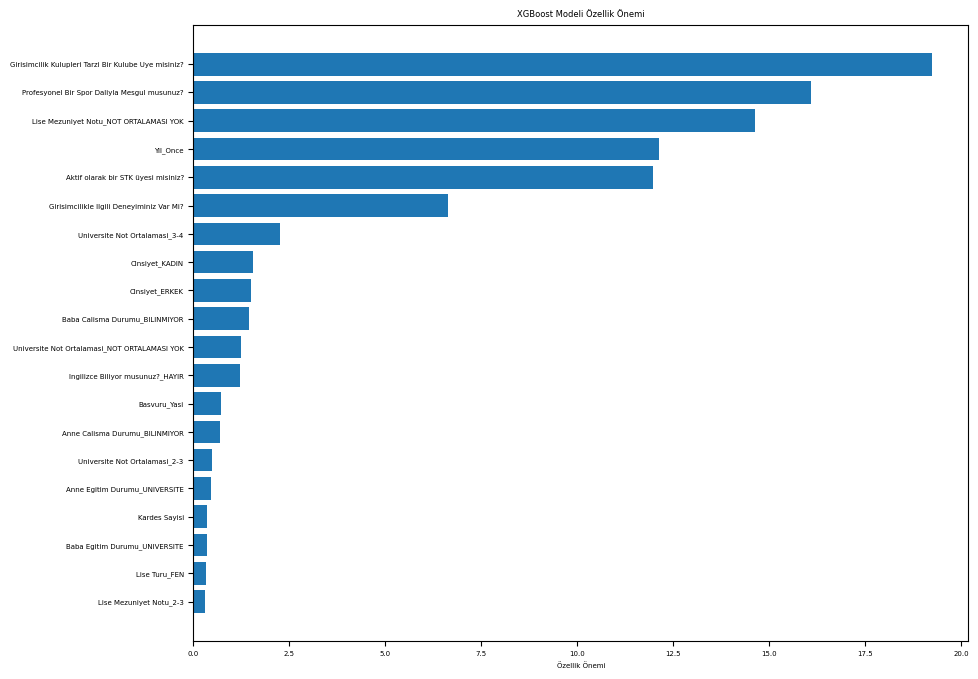

In [56]:
X_train, X_val, y_train, y_val, X_test = split(train_df, test_df)
predictions_catboost = modelcatboost(X_train, X_val, y_train, y_val, X_test)

In [57]:
test_id = pd.read_csv("/kaggle/input/datathon-2024/test_x.csv",encoding='utf-8',low_memory=False)
test_id["id"].shape
submission_df = pd.DataFrame({
    "id": test_id["id"],
    "Degerlendirme Puani": predictions_catboost
})


submission_df.to_csv('/kaggle/working/catboost_submission.csv', index=False)

***Private Score=*6.14**